In [1]:
import os
import zipfile

local_zip = 'train_SOaYf6m.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('data')
zip_ref.close()

In [2]:
import pandas as pd
import numpy as np

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("test_vc2kHdQ.csv")

In [4]:
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [5]:
train.shape, test.shape

((1646, 2), (706, 1))

In [6]:
train['emergency_or_not'] = train['emergency_or_not'].astype('str')
classes = train.emergency_or_not.unique().tolist()
classes

['0', '1']

In [7]:
import shutil
import random

train_directory = '.\\training'
val_directory = '.\\validation'

if not os.path.exists(train_directory):
    os.mkdir(train_directory)
if not os.path.exists(val_directory):
    os.mkdir(val_directory)

train_file_dir = '.\\data\\images'

files_toshow = []
labels_toshow = []

for class_ in classes:
    path_train = os.path.join(train_directory, class_)
    path_val = os.path.join(val_directory, class_)
    
    print(path_val)
    
    if os.path.isdir(path_train) | os.path.isdir(path_val):
        print('Already exists')
        filenames = train.groupby('emergency_or_not')['image_names'].get_group(class_).tolist()
        labels_toshow.append([class_] * 5)
        files_toshow.append([(train_file_dir + os.sep + file) 
                             for file in random.sample(filenames, 5)])
        
    else:
        os.mkdir(path_train)
        os.mkdir(path_val)
        
        print('Directory Created ', path_train)
        print('Directory Created ', path_val)
        
        filenames = train.groupby('emergency_or_not')['image_names'].get_group(class_).tolist()
        
        val_files = random.sample(filenames, 50)
        train_files = [file for file in filenames if file not in val_files]
        
        files_toshow.append([(train_file_dir + os.sep + file) 
                             for file in random.sample(filenames, 5)])
        labels_toshow.append([class_] * 5)
        
        source = [(train_file_dir + os.sep + file) for file in train_files]
        for f in source:
            shutil.copy(f, path_train)
        print('Class ', class_, ' Images Moved in Training Folder')
        print(class_,' having ', len(train_files), ' files in Training Folder')
        
        source = [(train_file_dir + os.sep + file) for file in val_files]
        for f in source:
            shutil.copy(f, path_val)
        print('Class ', class_, ' Images Moved in Validation Folder')
        print(class_,' having ', len(val_files), ' files in Validation Folder')

.\validation\0
Directory Created  .\training\0
Directory Created  .\validation\0
Class  0  Images Moved in Training Folder
0  having  915  files in Training Folder
Class  0  Images Moved in Validation Folder
0  having  50  files in Validation Folder
.\validation\1
Directory Created  .\training\1
Directory Created  .\validation\1
Class  1  Images Moved in Training Folder
1  having  631  files in Training Folder
Class  1  Images Moved in Validation Folder
1  having  50  files in Validation Folder


In [8]:
from matplotlib.cbook import flatten
files = list(flatten(files_toshow))
labels_train = list(flatten(labels_toshow))

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 5
pic_index = 0

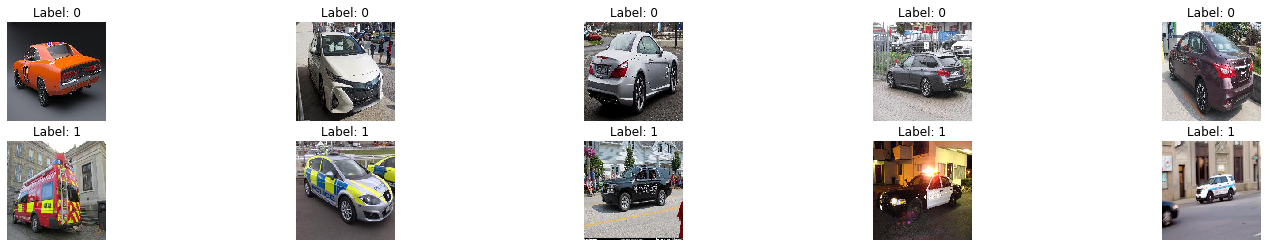

In [10]:
fig = plt.gcf()
#plt.figure(figsize=(28,28))
fig.set_size_inches(ncols * 5, nrows * 2)

for i, img_path in enumerate(files):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.title("Label: "+labels_train[i])
    plt.imshow(img)

plt.show()

In [63]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
tf.keras.backend.clear_session()

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    val_directory,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary')

Found 1546 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [65]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 8)       584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0

In [66]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adamax
tf.enable_eager_execution()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [67]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        print(logs.get('val_acc'))
        if(logs.get('val_acc')>=0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True
        return
            
callbacks = myCallback()

history = model.fit(
    train_generator,
    epochs=15,
    verbose=1,
    validation_data = validation_generator)

Epoch 1/15
194/194 [==============================] - 22s 113ms/step - loss: 0.6018 - acc: 0.6585 - val_loss: 0.6112 - val_acc: 0.7000
Epoch 2/15
194/194 [==============================] - 25s 128ms/step - loss: 0.4742 - acc: 0.7762 - val_loss: 0.5992 - val_acc: 0.7000
Epoch 3/15
194/194 [==============================] - 28s 143ms/step - loss: 0.4297 - acc: 0.8072 - val_loss: 0.5550 - val_acc: 0.7400
Epoch 4/15
194/194 [==============================] - 28s 143ms/step - loss: 0.3578 - acc: 0.8376 - val_loss: 0.5601 - val_acc: 0.7200
Epoch 5/15
194/194 [==============================] - 28s 143ms/step - loss: 0.3058 - acc: 0.8668 - val_loss: 0.5807 - val_acc: 0.7100
Epoch 6/15
194/194 [==============================] - 30s 154ms/step - loss: 0.2335 - acc: 0.9062 - val_loss: 0.4629 - val_acc: 0.8000
Epoch 7/15
194/194 [==============================] - 28s 143ms/step - loss: 0.1795 - acc: 0.9269 - val_loss: 0.5367 - val_acc: 0.8000
Epoch 8/15
194/194 [==============================] - 3

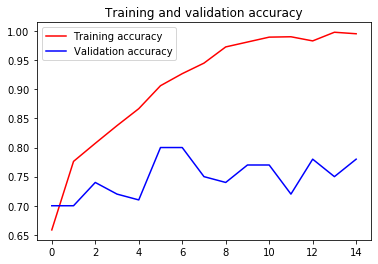

<Figure size 432x288 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

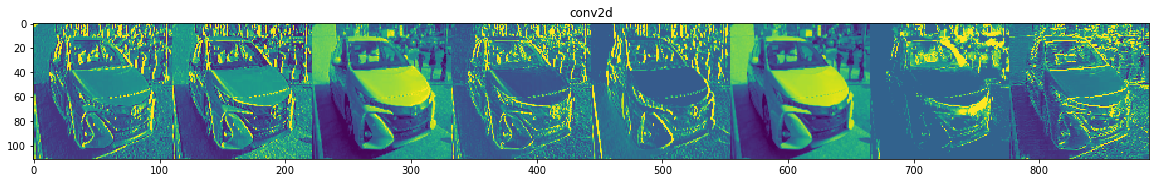

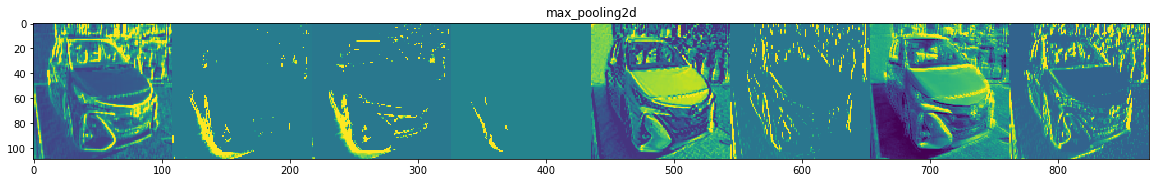

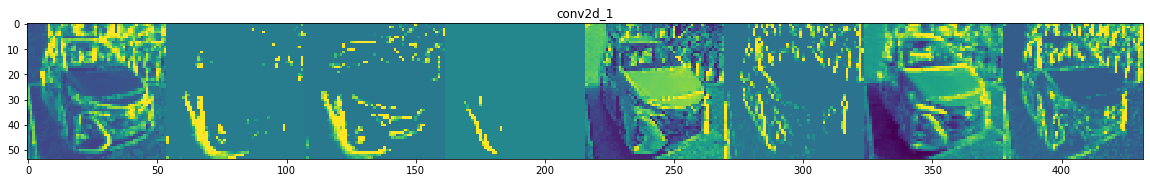

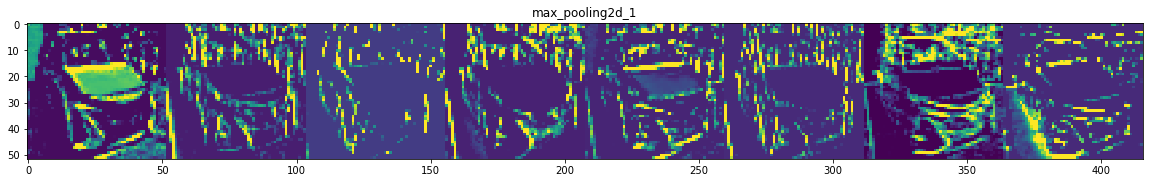

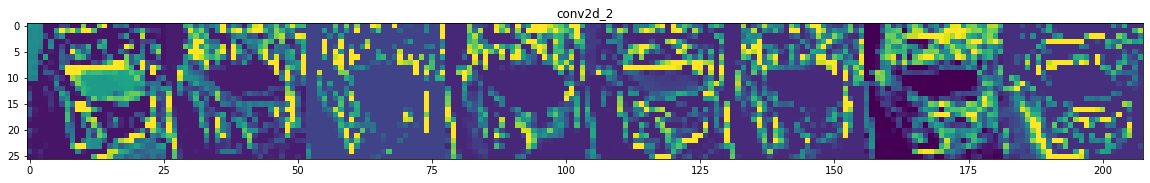

In [69]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = load_img(files[1], target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [70]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train.emergency_or_not)

LabelEncoder()

In [71]:
test_file_dir = '.\\data\\images'

test_fn = test.image_names.tolist()
test_files_path = [(test_file_dir + os.sep + file) for file in test_fn]

In [72]:
len(test_files_path), test.shape

(706, (706, 1))

In [73]:
from tensorflow.keras.preprocessing import image

pred_test = []
fns = []

for fn in test_files_path:
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    pred_test.append(round(classes[0][0]))
    fns.append(fn)

In [74]:
pred_test = [int(i) for i in pred_test]
df = {'image_names':test.image_names, 'emergency_or_not':encoder.inverse_transform(pred_test)}
submission = pd.DataFrame(df)
submission.to_csv('sub.csv', index=False)

In [75]:
submission.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [76]:
test_files = submission.sample(16)
files_test = [(test_file_dir + os.sep + file) for file in test_files.image_names.tolist()]
label_test = test_files.emergency_or_not.tolist()

<Figure size 432x288 with 0 Axes>

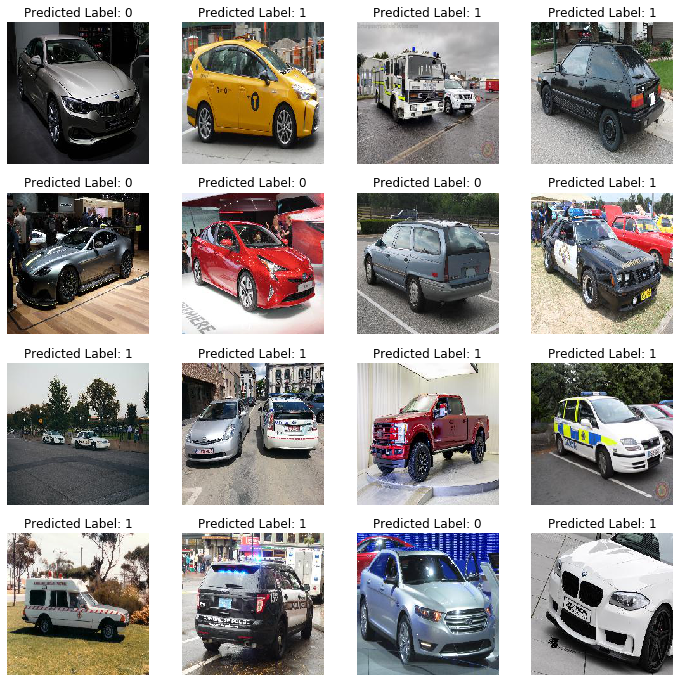

In [77]:
nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
plt.figure(figsize=(12,12))

for i, img_path in enumerate(files_test):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.title("Predicted Label: "+label_test[i])
    plt.imshow(img)

plt.show()

In [78]:
submission['emergency_or_not'].value_counts()

0    363
1    343
Name: emergency_or_not, dtype: int64

In [37]:
submission['emergency_or_not'].value_counts()

0    479
1    227
Name: emergency_or_not, dtype: int64